In [1]:
# --- Standard library ---
import sys
import os
from os.path import join
import time

# --- Third-party scientific stack ---
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Machine learning / statistics ---
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.cluster import AffinityPropagation

# --- SciPy ---
from scipy.linalg import LinAlgError, qr, svd
from scipy.sparse import csgraph

# --- Utilities ---
from tqdm import tqdm
import joblib
from joblib import parallel_backend
import numexpr as ne

# --- Local / custom modules ---
import fpsample



# Self-written libraries
sys.path.append(join(os.getcwd(), "library"))
import SPC

# Loading

In [2]:
# File path
# Input your own file path here
file_path = r"C:\used\data\Clustering_Analysis\Clustering_Analysis\Correlation_Map.bin"

# Use memory mapping to read the large matrix
fragment = np.memmap(
    file_path,
    dtype=np.float64,   # Explicitly specify data type
    mode="r",           # Read-only mode
    shape=(28800, 28800)
)

# Time index
t_index = np.arange(fragment.shape[0])
idx=np.arange(fragment.shape[0])

In [3]:
# --- Labels Loading ---
results = pd.read_csv(
    r'D:\used\Log_Data_Coherent_Correlation_Imaging.txt',
    sep="\t"
)

# Rename columns properly (removed trailing empty column name)
results.columns = [
    'Timestamp', 'Helicity', 'State', 'Mode',
    'Topography_Nr', 'Translation_y', 'Translation_x', 'FileName',''
]

# Select the row of interest (example: idx+1)
mode_value = results.loc[idx + 1, 'Mode']
state_value = results.loc[idx + 1, 'State']

# Find indices corresponding to "Not assigned"
filter_index = np.where(mode_value == ' Not assigned')
print("Indices with 'Not assigned':", filter_index)

Indices with 'Not assigned': (array([  614,   615,   632,   633,   637,  1738,  1739,  1740,  2007,
        2678,  2694,  2695,  2696,  2719,  2720,  2722,  2734,  2735,
        2815,  2824,  2835,  2839,  2843,  2854,  2863,  2865,  2867,
        2874,  2944,  2969,  2976,  2983,  3011,  3012,  3030,  3047,
        3048,  3049,  3050,  3054,  3055,  3072,  3183,  3198,  3839,
        3847,  3853,  3854,  3954,  3988,  4040,  4520,  4745,  4790,
        4796,  4994,  5120,  5129,  5363,  5364,  5477,  5572, 11508,
       11597, 11598, 11599, 11839, 11858, 11874, 16375, 16386, 16476,
       16477, 16478, 16479, 18729, 18730, 18731, 18732, 18734, 18735,
       18737, 18739, 18964, 18983, 18984, 18986, 19005, 19045, 19047,
       19107, 19169, 19220, 19221, 19301, 19311, 19630, 19658, 19743,
       19746, 19751, 19758, 19872, 19922, 19957, 19966, 19967, 19990,
       19991, 20047, 20062, 20069, 20072, 20073, 20074, 20085, 20086,
       20098, 20200, 20201, 20202, 20203, 20475, 20519, 2053

In [4]:
# Convert mode label to integer 
modes_encoded, unique_items = pd.factorize(mode_value)
print("Unique items:", unique_items)
#print("Encoded modes:", modes_encoded)

# Convert to numpy arrays
modes = modes_encoded.astype(float)
states = state_value.to_numpy().astype(float)

# Replace "Not assigned" entries with NaN
modes[filter_index]=np.nan
states[filter_index]=np.nan


Unique items: Index([' 1-1', ' 1-2', ' 1-4', ' Not assigned', ' 2-5', ' 2-1', ' 3-1', ' 4-1',
       ' 5-5', ' 6-1', ' 7-1', ' 7-2', ' 2-8', ' 2-9', ' 2-3', ' 2-4', ' 2-7',
       ' 8-1', ' 9-1', ' 10-1', ' 11-1', ' 12-1', ' 13-1', ' 14-3', ' 14-1',
       ' 14-2', ' 2-6', ' 5-6', ' 5-1', ' 5-4', ' 5-2', ' 5-3', ' 7-5', ' 7-6',
       ' 7-3', ' 7-4', ' 15-1', ' 16-2', ' 16-1', ' 17-1', ' 18-1', ' 19-2',
       ' 20-1', ' 21-1', ' 22-1', ' 23-4', ' 24-1', ' 19-1', ' 23-1', ' 23-2',
       ' 23-3', ' 25-1', ' 15-2', ' 6-2', ' 2-11', ' 2-2', ' 26-1', ' 27-3',
       ' 2-10', ' 27-2', ' 27-1', ' 27-4', ' 1-3', ' 27-5', ' 28-1', ' 2-12',
       ' 29-1', ' 30-1', ' 27-6', ' 31-3', ' 32-1', ' 31-1', ' 31-2'],
      dtype='object')


In [5]:
# --- Relabel function ---
def relabel(labels):
    """
    Relabels an array of labels:
    1. Replace each unique label with the median index of its occurrences.
    2. Reassign labels to consecutive integers starting from 0.
    NaN values are preserved.
    """
    labels = np.array(labels, dtype=float)

    # Get unique non-NaN items
    unique_items = np.unique(labels[~np.isnan(labels)])
    print("Unique items before relabeling:", unique_items)

    # Step 1: Replace each label with the median index of its occurrences
    for item in unique_items:
        indices = np.where(labels == item)[0]
        median_index = indices[len(indices) // 2]  # middle occurrence
        labels[indices] = median_index

    # Step 2: Normalize labels to consecutive integers
    unique_items = np.sort(np.unique(labels[~np.isnan(labels)]))
    for new_label, old_value in enumerate(unique_items):
        labels[labels == old_value] = new_label

    return labels

# Apply relabeling
modes = relabel(modes)
states = relabel(states)

Unique items before relabeling: [ 0.  1.  2.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.]
Unique items before relabeling: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]


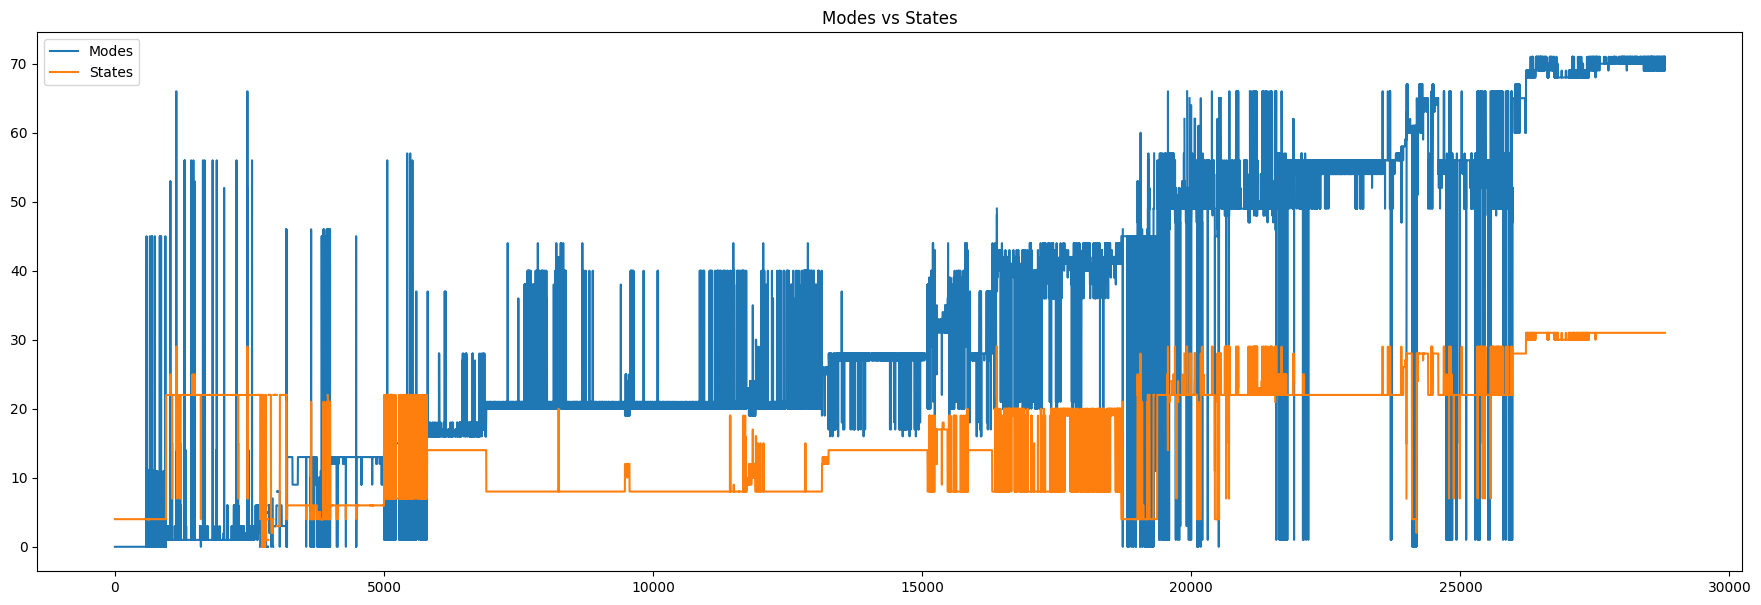

In [6]:
plt.figure(figsize=(22, 7))
plt.plot(modes,label='Modes')
plt.plot(states,label='States')
plt.legend()
plt.title("Modes vs States")
plt.show()

# Clustering process

In [7]:
# ============================================
# Iterative Spectral Clustering Workflow
# ============================================

# Initialize cluster dictionary
cluster_dict = {
    "Cluster_Nr": 0,                                # Cluster index number
    "Cluster_Frames": np.arange(fragment.shape[0]), # All frames initially belong to cluster 0
    "Nr_Frames": 0,                                 # Number of frames in cluster (updated later)
    "Threshold": 0,                                 # Reclustering threshold (updated later)
    "Order": 0,                                     # Order of correlation (0 for first cluster, >0 for subclusters)
    "Metric": 0,                                    # Similarity metric used ("correlation" or "cosine")
    "eigenvalues": np.arange(fragment.shape[0]),    # Placeholder for eigenvalues
}

# Store clusters in a list
cluster = [cluster_dict]

# Clustering parameters
first_threshold = 0.05   # Threshold for first cluster
rc_threshold = 0.15     # Threshold for reclustering subclusters
force_iterations = 3     # Force splitting of clusters for how many iterations
order = 1                # Correlation order (1 or 2)
metric = "correlation"   # Similarity metric ("correlation" or "cosine")

# Reset loop variables
cluster_idx = 0
stop = False

# Close all previous plots
plt.close("all")

# ============================================
# Iterative loop over clusters
# ============================================
while not stop:
    print("")
    print(f"=========== Clustering of Cluster Index: {cluster_idx} ===========")

    # Only process clusters with sufficient frames
    if len(cluster[cluster_idx]["Cluster_Frames"]) > 30:

        # --- Sampling ---
        if cluster_idx == 0:
            # First cluster: sample directly from full fragment space
            Sampler_1 = SPC.Sampler(
                cluster[cluster_idx]["Cluster_Frames"],
                feature_space=fragment,
                max_samples=500,
                min_samples=500
            )
            train_idx, test_idx, train_SN, test_SN = Sampler_1.shuffle(
                proportion=0.5, method="random"
            )
            print(len(cluster[cluster_idx]["Cluster_Frames"]),
                  len(train_idx), len(test_idx), len(test_SN))

            # Build correlation maps
            train_corr = SPC.reconstruct_correlation_map(
                train_idx, train_idx, fragment, 0, metric
            )
            test_corr = SPC.reconstruct_correlation_map(
                test_idx, train_idx, fragment, 0, metric
            ) if len(test_idx) != 0 else None

            threshold = first_threshold

        else:
            # Subsequent clusters: sample from sub-fragment space
            Sampler_2 = SPC.Sampler(
                cluster[cluster_idx]["Cluster_Frames"],
                feature_space=fragment[np.ix_(
                    cluster[cluster_idx]["Cluster_Frames"],
                    cluster[cluster_idx]["Cluster_Frames"]
                )],
                max_samples=500,
                min_samples=500
            )
            train_idx, test_idx, train_SN, test_SN = Sampler_2.shuffle(
                proportion=0.2, method="random"
            )
            print(len(cluster[cluster_idx]["Cluster_Frames"]),
                  len(train_idx), len(test_idx), len(test_SN))

            # Build correlation maps
            train_corr = SPC.reconstruct_correlation_map(
                train_idx, train_idx, fragment, order, metric
            )
            test_corr = SPC.reconstruct_correlation_map(
                test_idx, train_idx, fragment, order, metric
            ) if len(test_idx) != 0 else None

            threshold = rc_threshold

        # --- Store cluster parameters ---
        cluster[cluster_idx]["Nr_Frames"] = len(train_idx) + len(test_idx)
        cluster[cluster_idx]["Order"] = order
        cluster[cluster_idx]["Metric"] = metric
        cluster[cluster_idx]["Threshold"] = threshold

        # --- Spectral Embedding ---
        print("Calculating Clustering")
        try:
            eigenvalues, eigenvectors, Laplacian_mat, norm_affinity_mat = SPC.Spectral_embeding(
                train_corr, sigma_nn=2
            )

            # Save eigen info
            cluster[cluster_idx]["eigenvalues"] = eigenvalues
            cluster[cluster_idx]["eigenvectors"] = eigenvectors
            cluster[cluster_idx]["eigenvec_shape"] = np.shape(eigenvectors)

            print(f"Smallest Eigenvalue = {eigenvalues[1]:.4f}")

            # --- Reclustering condition ---
            print("Recluster")
            if eigenvalues[1] < threshold:
                start_time = time.time()

                if cluster_idx == 0:
                    # For first cluster: number of clusters = count of eigenvalues below threshold
                    nr_cluster = np.sum(eigenvalues < threshold)
                else:
                    # For subclusters: use multiple criteria
                    nr_max_cluster = np.sum(eigenvalues < threshold)
                    nr_min_cluster = np.sum(eigenvalues < threshold / 10)
                    nr_gap_cluster = SPC.eigerngap(eigenvalues[:nr_max_cluster + 1])

                    #Choose cluster number based on gap/min criteria
                    #nr_cluster = np.max([nr_gap_cluster, nr_min_cluster])
                    nr_cluster = 2

                    print(f"nr_max_cluster {nr_max_cluster}! Recluster number {nr_cluster}!")

                print(f"Reclustering condition satisfied "
                      f"(Eigenvalue = {eigenvalues[nr_cluster - 1]:.4f})! "
                      f"Recluster number {nr_cluster}")

                # --- Train clustering ---
                cluster_space, train_labels, model = SPC.clustering(
                    eigenvectors,
                    n_components=nr_cluster,
                    n_clusters=nr_cluster,
                    assign_labels="kmeans"
                )

                # --- Test clustering ---
                if len(test_idx) != 0:
                    test_norm_affinity = SPC.local_scaled_affinity(test_corr, train_corr, k=2)
                    test_embed = np.dot(
                        test_norm_affinity @ norm_affinity_mat,
                        eigenvectors[:, :nr_cluster] / (1 - eigenvalues[:nr_cluster])
                    )
                    test_labels = model.predict(test_embed)
                else:
                    test_labels = []

                # --- Merge train/test labels ---
                labels = np.zeros(len(train_labels) + len(test_labels))
                labels[train_SN] = train_labels
                labels[test_SN] = test_labels

                # Timing
                end_time = time.time()
                print(f"Time for embedding: {end_time - start_time:.2f} seconds")

                # --- Process sub-clusters ---
                cluster = SPC.process_cluster(
                    model, cluster, cluster_idx, labels,
                    save=True
                )

            else:
                print(f"Cluster {cluster_idx} does not satisfy reclustering "
                      f"(smallest eigenvalue: {eigenvalues[1]:.4f})!\n")

        except Exception as e:
            print(f"Cluster {cluster_idx} failed due to error: {e}\n")

    else:
        print("Small cluster size: Skipping!")

    # --- Update index ---
    cluster_idx += 1
    if cluster_idx >= len(cluster):
        stop = True

# Final feedback
print("Iterative clustering algorithm finished!")

# Remove empty clusters
cluster = list(filter(None, cluster))

print(f"You determined {len(cluster)} clusters! (Threshold {threshold:.2f})")



=========== Clustering of Cluster Index: 0 ===========
28800 500 28300 28300
Calculating Clustering
Smallest Eigenvalue = -0.0206
Recluster
Reclustering condition satisfied (Eigenvalue = 0.0253)! Recluster number 7
Time for embedding: 1.10 seconds
Creating sub-cluster: 0-0.0
Saving subcluster 0-0.0 as new cluster 1.0
Creating sub-cluster: 0-1.0
Saving subcluster 0-1.0 as new cluster 2.0
Creating sub-cluster: 0-2.0
Saving subcluster 0-2.0 as new cluster 3.0
Creating sub-cluster: 0-3.0
Saving subcluster 0-3.0 as new cluster 4.0
Creating sub-cluster: 0-4.0
Saving subcluster 0-4.0 as new cluster 5.0
Creating sub-cluster: 0-5.0
Saving subcluster 0-5.0 as new cluster 6.0
Creating sub-cluster: 0-6.0
Saving subcluster 0-6.0 as new cluster 7.0

=========== Clustering of Cluster Index: 1 ===========
2581 500 2081 2081
Calculating Clustering
Smallest Eigenvalue = 0.0165
Recluster
nr_max_cluster 3! Recluster number 2!
Reclustering condition satisfied (Eigenvalue = 0.0165)! Recluster number 2
Time

# Reorder and Save

In [8]:
# Print number of clusters
print(f"Number of clusters: {len(cluster)}")

# Initialize labels with -1
my_labels = np.full(fragment.shape[0], -1, dtype=float)

# Assign cluster indices to frames
for i, c in enumerate(cluster):
    my_labels[c['Cluster_Frames']] = i

# Mask out filtered indices
my_labels[filter_index] = np.nan

# Relabel 
labels = relabel(my_labels)


Number of clusters: 38
Unique items before relabeling: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37.]


In [9]:
# Save clustering result

# Wrap into an xarray DataArray with dimension labels
data = xr.DataArray(
    labels,
    dims=("label"),
    coords={"label": np.arange(np.shape(labels)[0])},
    name="my_label"
)


# Save to NetCDF (common scientific format)
fname="Clustering_result.nc"
if os.path.exists(fname):
    os.remove(fname)
data.to_netcdf(fname)

# Analyse Result

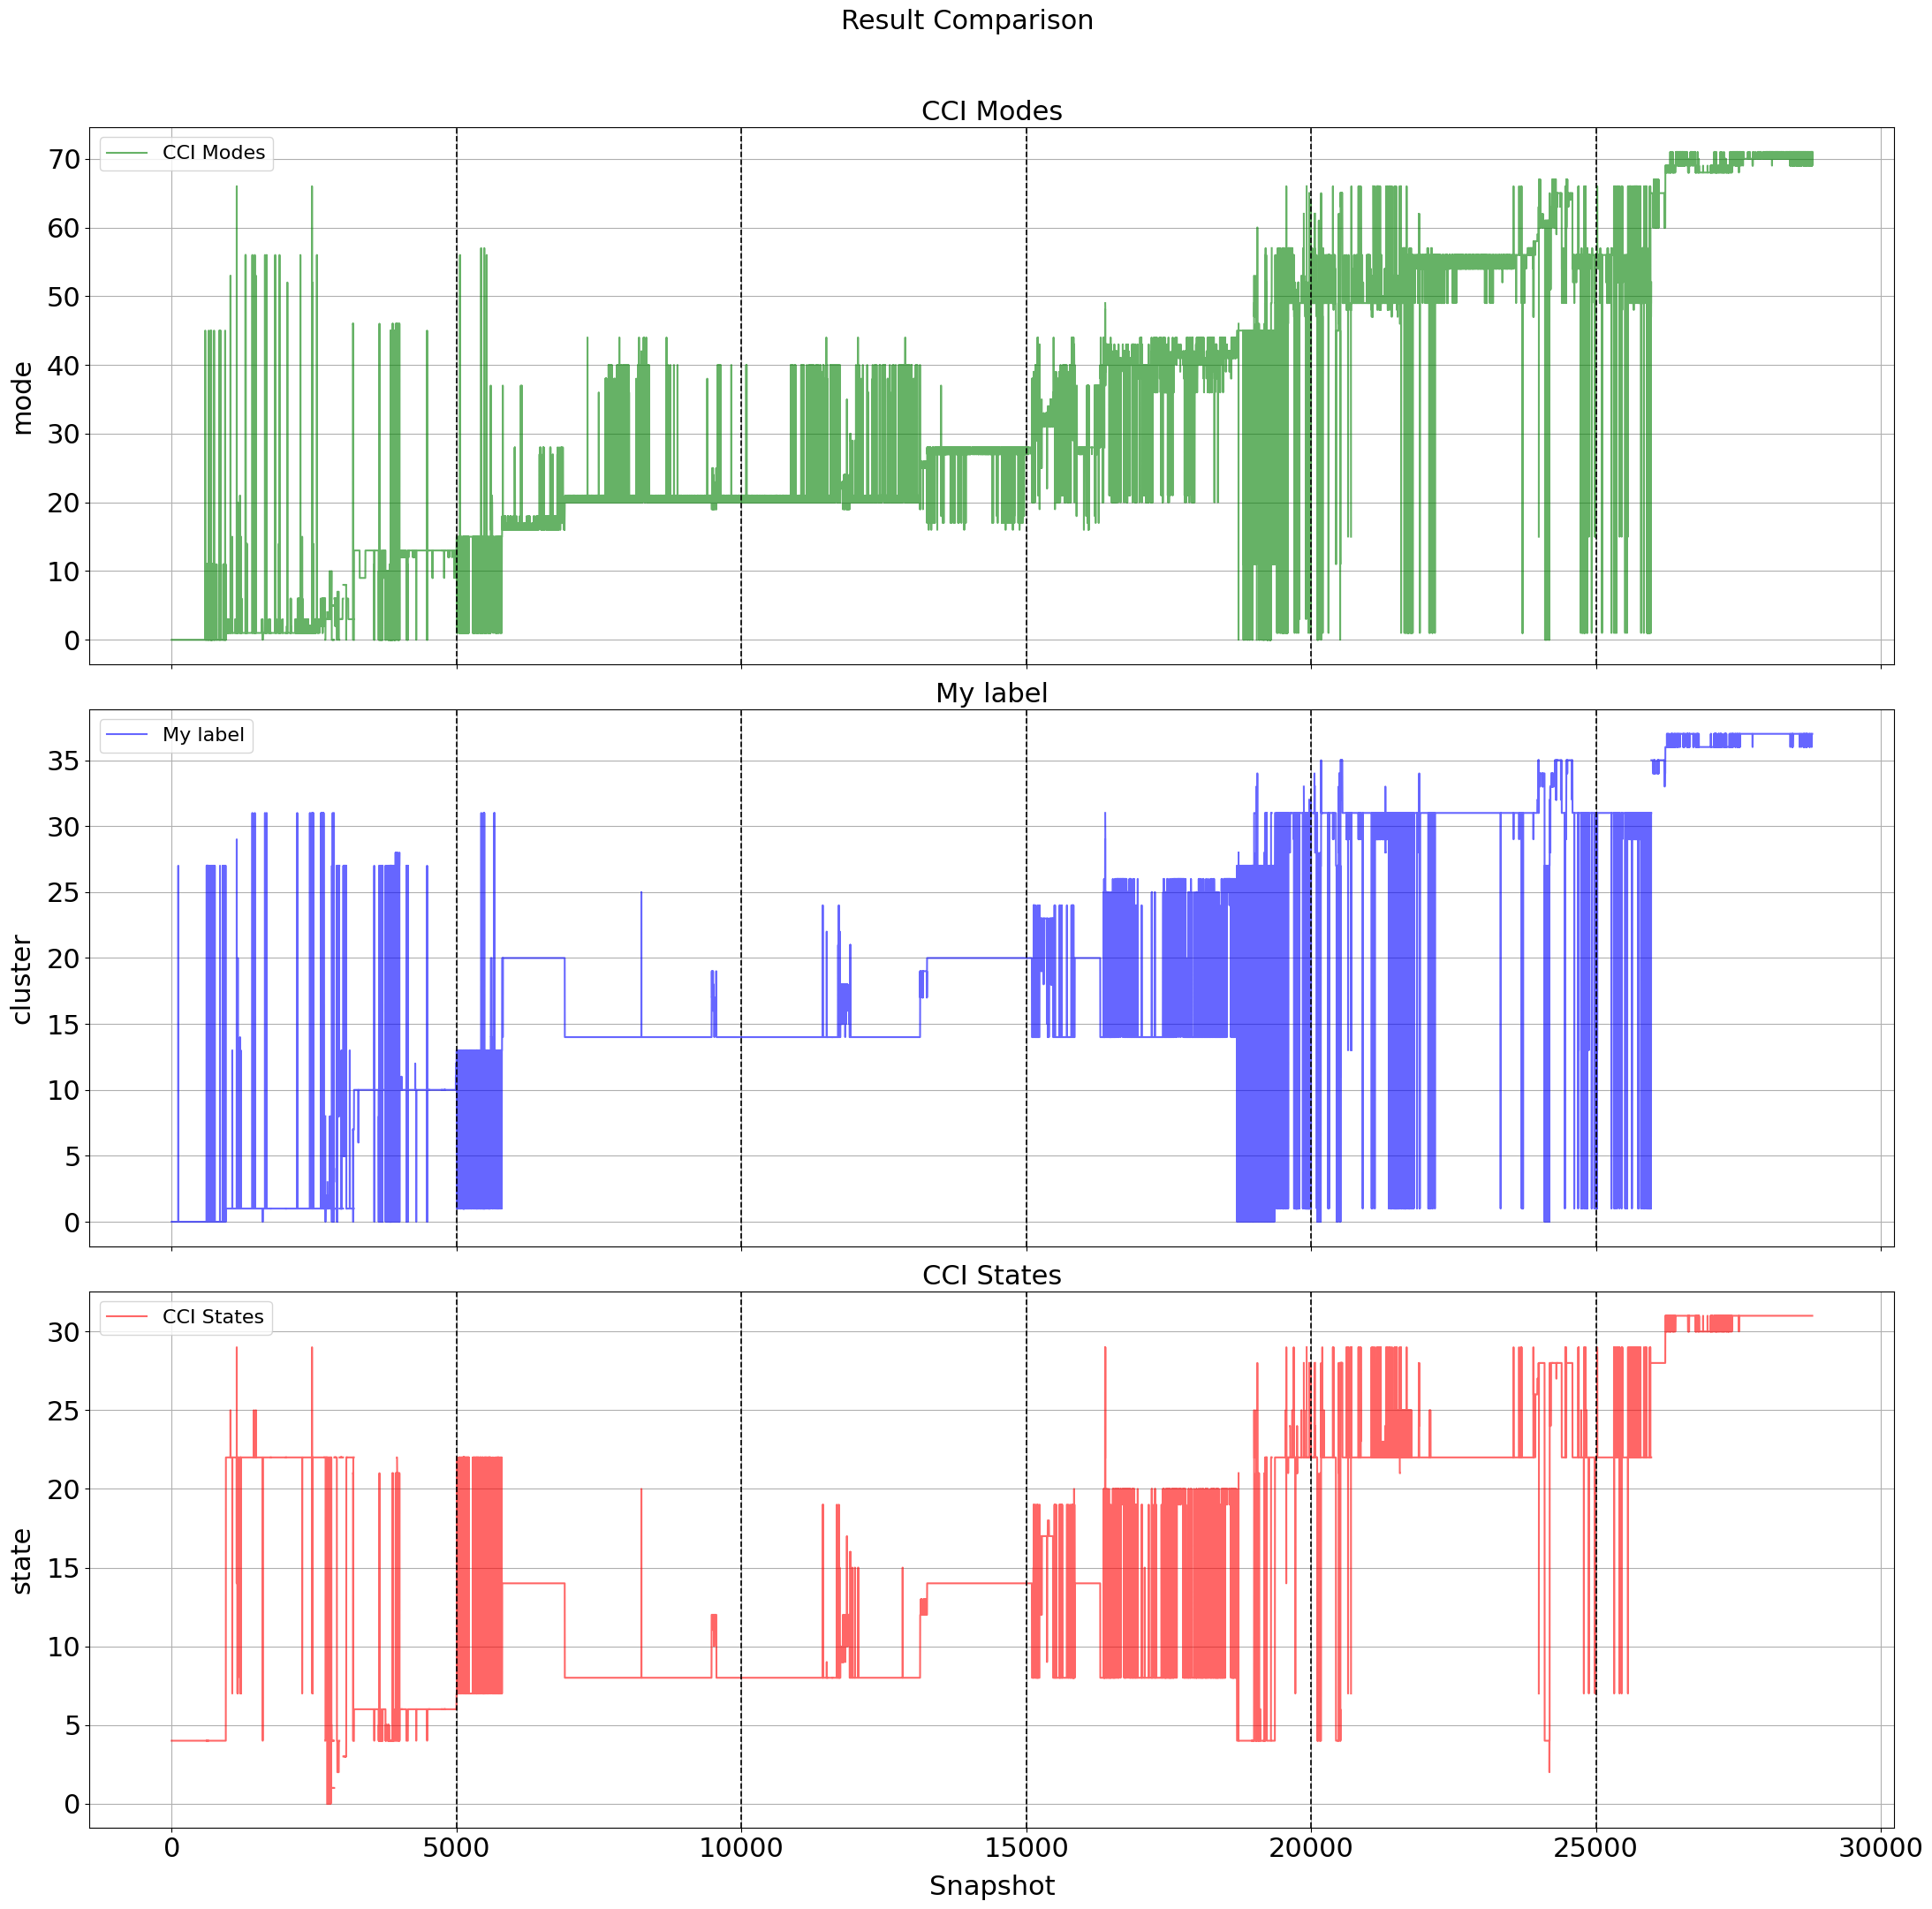

In [10]:
show_idx = np.arange(0, 28800)
compare_xs = [5000, 10000, 15000, 20000, 25000]

fig, axs = plt.subplots(3, 1, figsize=(22, 22), sharex=True)

# Modes
axs[0].plot(modes[show_idx], label='CCI Modes', alpha=0.6, color='green')
axs[0].legend(fontsize=16) 
axs[0].set_title("CCI Modes", fontsize=22)

# My label
axs[1].plot(labels[show_idx], label='My label', alpha=0.6, color='blue')
axs[1].legend(fontsize=16)
axs[1].set_title("My label", fontsize=22)

# States
axs[2].plot(states[show_idx], label='CCI States', alpha=0.6, color='red')
axs[2].legend(fontsize=16)
axs[2].set_title("CCI States", fontsize=22)

# 
axs[0].set_ylabel('mode', fontsize=22, labelpad=10) 
axs[1].set_ylabel('cluster', fontsize=22, labelpad=10) 
axs[2].set_ylabel('state', fontsize=22, labelpad=10) 
for ax in axs:
    ax.tick_params(axis='both', labelsize=22)         
    ax.grid(True)
    for x in compare_xs:
        ax.axvline(x=x, color='black', linestyle='--', linewidth=1.2)

axs[2].set_xlabel('Snapshot', fontsize=22, labelpad=10)
fig.suptitle("Result Comparison", fontsize=22)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [11]:
def benchmark_assignment(test_assignment, reference_assignment):
    test_assignment = np.squeeze(test_assignment)
    reference_assignment = np.squeeze(reference_assignment)

    # Which clusters do we have?
    clusters_test = np.unique(test_assignment[~np.isnan(test_assignment)])
    clusters_ref = np.unique(reference_assignment[~np.isnan(reference_assignment)])

    sz = np.max(
        [
            len(clusters_test),
            len(clusters_ref),
        ]
    )

    # Split test clusters
    test_cluster_matrix = np.zeros(
        (sz, sz, len(test_assignment)),
        dtype=bool,
    )
    for i in range(len(clusters_test)):
        tmp = test_assignment == i
        test_cluster_matrix[i, :] = tmp[np.newaxis, :]

    # Split reference clusters
    clusters_ref = np.unique(reference_assignment[~np.isnan(reference_assignment)])

    ref_cluster_matrix = np.zeros((sz, len(reference_assignment)))
    for i in range(len(clusters_ref)):
        tmp = reference_assignment == i
        ref_cluster_matrix[i, :] = tmp[np.newaxis, :]

    # Compare test and reference clusters
    comparison = test_cluster_matrix * ref_cluster_matrix[np.newaxis, ...]

    # What is the percentage of overlap of each cluster?
    spread = np.sum(comparison, axis=-1)
    nr_frames = np.sum(test_cluster_matrix, axis=-1)
    spread_percentage = spread / nr_frames
    spread_percentage[np.isinf(spread_percentage)] = 0

    # What is the error_rate?
    error = 1 - np.max(spread_percentage, axis=-1)
    error_rate = error * (nr_frames[:, 0] / np.sum(nr_frames[:, 0]))
    total_error = np.nansum(error_rate)

    # To-do: Put into pandas dataframe

    # Create some nice plots
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))


    mi, ma = np.nanpercentile(spread[spread != 0], [5, 95])
    m00 = ax[0, 0].imshow(np.transpose(spread), vmin=mi, vmax=ma)
    ax[0, 0].set_ylabel("Reference assignment cluster (expanded)")
    ax[0, 0].set_xlabel("Test assignment cluster (expanded)")
    ax[0, 0].set_ylim([0, len(clusters_ref)])
    # cb00 = plt.colorbar(m00, label="Distribution in reference clusters")

    mi, ma = np.nanpercentile(spread_percentage[spread_percentage != 0], [1, 99])
    m01 = ax[0, 1].imshow(np.transpose(spread_percentage), vmin=mi, vmax=ma)
    ax[0, 1].set_ylabel("Reference assignment cluster (expanded)")
    ax[0, 1].set_xlabel("Test assignment cluster (expanded)")
    ax[0, 1].set_ylim([0, len(clusters_ref)])
    # cb01 = plt.colorbar(m01, label="Distribution in reference clusters in %")

    ax[1, 0].plot(error)
    ax[1, 0].grid()
    ax[1, 0].set_xlabel("Test cluster")
    ax[1, 0].set_ylabel("Relative error of each cluster")

    ax[1, 1].plot(100 * error_rate)
    ax[1, 1].grid()
    ax[1, 1].set_xlabel("Test cluster")
    ax[1, 1].set_ylabel("Cluster Error weighted with total number of frames in %")

    print("Your total assignment error: %.2f %%" % (100 * total_error))

    return 100 * total_error

Your total assignment error: 4.35 %


4.347674378031336

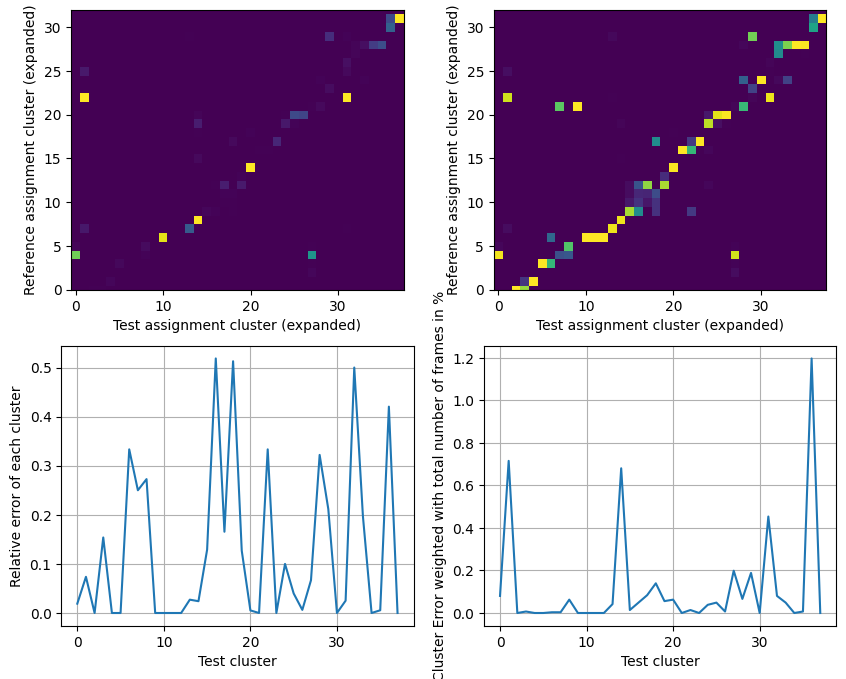

In [12]:
benchmark_assignment(labels,states)